In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
import scipy.io
import datetime, time
import pandas as pd
import my_utils as myf
from matplotlib.gridspec import GridSpec

#### Open CESM model output
The files I read in here were created in 0_process_moc.ipynb
They are the maximum of the total overturning streamfunction between 500 and 2000 m

In [2]:
mydir = '/glade/work/lettier/archived_data/202212_data_paper_nudge_winds_amoc/moc/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if '.nc' in f]

listds = []
for f in myfiles:
    ds = xr.open_dataset(f)[['moc_rapid','ekman']].rename({'moc_rapid':'MOC'})
    myname = str(f.split('/')[-1].split('natl')[0])[:-15]
    mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
    if myname=='CESM1':
        myname = 'CESM1FO'
        mytime = pd.date_range(start="1979-01-01",end="2016-12-31", freq='M')
    ds['time'] = mytime
    ds['names'] = myname
    ds = ds.set_coords('names')
    listds.append(ds)
ds = xr.concat(listds,dim='names').groupby('time.year').mean(dim='time')

In [3]:
mydir = '/glade/work/lettier/archived_data/202212_data_paper_nudge_winds_amoc/buoyancy_spg/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if '.nc' in f and 'buoyancy' in f ]

listds = []
for f in myfiles:
    name = f.split('/')[-1].split('.')[0]
    if name in ds.names.values:
        bds = xr.open_dataset(f)
        if len(bds.B.shape)==2:
            bds = bds.isel(z_t=0)
        bds = bds.drop('z_t').groupby('time.year').mean(dim='time')
        bds = bds.set_coords('names')
        listds.append(bds)
bds = xr.concat(listds,dim='names')

In [4]:
ds = xr.merge([ds,bds]).sel(year=slice(2004,2016))

Set some properties for plotting

In [5]:
lineplotprop = myf.set_line_prop(ds.names.values)
lineplotprop['nudge_era_1950_ens01']['label'] = 'NUDGE-ERA5 (45-90N and 45-90S)'

In [6]:
mynames = ['LENS01', 'LENS02', 'LENS03', 'LENS04', 'LENS05',
       'LENS06', 'LENS07', 'LENS08', 'LENS09', 'LENS10', 'LENS11',
       'LENS12', 'LENS13', 'LENS14', 'LENS15', 'LENS16', 'LENS17',
       'LENS18', 'LENS19', 'LENS20', 'LENS21', 'LENS22', 'LENS23',
       'LENS24', 'LENS25', 'LENS26', 'LENS27', 'LENS28', 'LENS29',
       'LENS30', 'LENS31', 'LENS32', 'LENS33', 'LENS34', 'LENS35',
       'CESM1FO',  'nudge_era_1950_ens01',
        'nudge_era_archi', 'nudge_era_arclo', 'nudge_era_high',
       'anom_nudge_era',  'anom_nudge_era_high',
       'anom_nudge_era_low',
       'nudge_era_MLN_archi', 'nudge_era_NH_archi_v2',
       'nudge_era_NH_arclo', 'nudge_era_NH_high', 'nudge_era_NH_low',
        'nudge_era_SH_archi_v2', 'nudge_era_SH_arclo', 'nudge_era_SH_high',
        'anom_nudge_era_60', 'anom_nudge_era_60_archi',
       'anom_nudge_era_60_arclo']

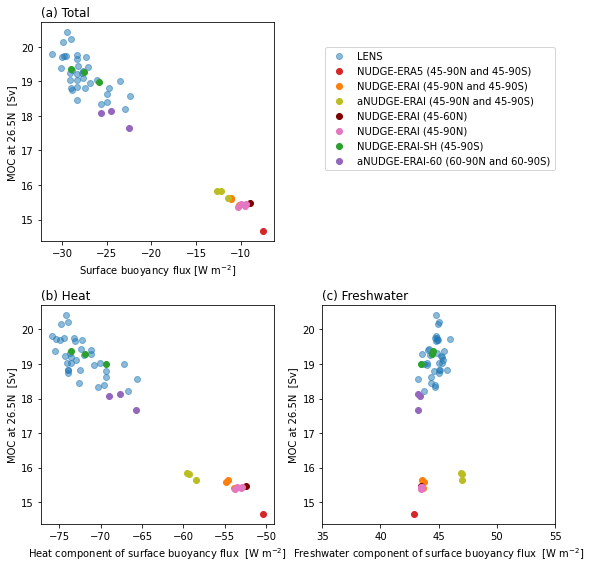

In [7]:
fig = plt.figure(figsize=(8,8))
                 
ax = plt.subplot(2,2,1)

for n, name in enumerate(mynames):
    if 'FO' not in name:
        ax.scatter(ds.sel(names=name).Q.mean(dim='year'), ds.sel(names=name).MOC.mean(dim='year'), 
                   c=lineplotprop[name]['c'], 
                   alpha =lineplotprop[name]['alpha'],label = lineplotprop[name]['label'] ) 

ax.set_title('')
ax.set_xlabel('Surface buoyancy flux [W m$^{-2}$]')  
ax.set_ylabel('MOC at 26.5N  [Sv]') 
ax.set_title('(a) Total',loc='left')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(),loc=(.55,.7))

                 
ax = plt.subplot(2,2,3)
for n, name in enumerate(mynames):
    if 'FO' not in name:
        ax.scatter(ds.sel(names=name).Q_HF.mean(dim='year'), ds.sel(names=name).MOC.mean(dim='year'), 
                   c=lineplotprop[name]['c'], 
                   alpha =lineplotprop[name]['alpha'],label = lineplotprop[name]['label'] ) 

ax.set_title('(b) Heat',loc='left')
ax.set_xlabel('Heat component of surface buoyancy flux  [W m$^{-2}$]')  
ax.set_ylabel('MOC at 26.5N  [Sv]') 

ax = plt.subplot(2,2,4)
for n, name in enumerate(mynames):
    if 'FO' not in name:
        ax.scatter(ds.sel(names=name).Q_FW.mean(dim='year'), ds.sel(names=name).MOC.mean(dim='year'), 
                   c=lineplotprop[name]['c'], 
                   alpha =lineplotprop[name]['alpha'],label = lineplotprop[name]['label'] ) 

ax.set_xlim([35,55])
ax.set_title('(c) Freshwater',loc='left')
ax.set_xlabel('Freshwater component of surface buoyancy flux  [W m$^{-2}$]')  
ax.set_ylabel('MOC at 26.5N  [Sv]') 

plt.tight_layout()
plt.show()
fig.savefig('figs/mainFig3.pdf', dpi=500, bbox_inches='tight')
plt.close()